<a href="https://colab.research.google.com/github/farahbakhsh3/X1/blob/master/Tax_Predict_Log.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

fname = './tax_Dataset_Log.txt'
f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split('\t')
lines = lines[1:-1]
print(header, len(header))
print('Data lines: %d' %len(lines))

['dar_log', 'sal', 'sen', 'sex', 'post4', 'Faliat_sharh', 'Athadieh', 'Marge_Gavaz', 'Vaziat_Falie', 'Mash_Mad', 'Faliat_Asli', 'Parvand_Size'] 12
Data lines: 103180


In [0]:
import numpy as np

float_data = np.zeros((len(lines), len(header)))
float_target = np.zeros(len(lines))
for i, line in enumerate(lines[:]):
    try:
        values = [float(x) for x in line.split('\t')]
        float_data[i, :] = values[:]
        float_target[i] = values[0]
    except:
        print(i)
# float_data = np.concatenate((float_data, np.zeros(10).reshape(1,10)))
# float_target = np.concatenate(([0], float_target))

In [3]:
float_data[0:4] , float_target[0:4]

(array([[2.03742650e+00, 1.00000000e+00, 2.90000000e+01, 0.00000000e+00,
         1.00000000e+00, 1.43600000e+03, 2.07700000e+03, 0.00000000e+00,
         0.00000000e+00, 2.00000000e+00, 3.90000000e+01, 0.00000000e+00],
        [2.18184359e+00, 2.00000000e+00, 2.90000000e+01, 0.00000000e+00,
         8.00000000e+00, 1.43600000e+03, 2.07700000e+03, 0.00000000e+00,
         0.00000000e+00, 2.00000000e+00, 3.90000000e+01, 0.00000000e+00],
        [2.17026172e+00, 3.00000000e+00, 2.90000000e+01, 0.00000000e+00,
         8.00000000e+00, 1.43600000e+03, 2.07700000e+03, 0.00000000e+00,
         0.00000000e+00, 2.00000000e+00, 3.90000000e+01, 0.00000000e+00],
        [2.22010809e+00, 4.00000000e+00, 2.90000000e+01, 0.00000000e+00,
         8.00000000e+00, 1.43600000e+03, 2.07700000e+03, 0.00000000e+00,
         0.00000000e+00, 2.00000000e+00, 3.90000000e+01, 0.00000000e+00]]),
 array([2.0374265 , 2.18184359, 2.17026172, 2.22010809]))

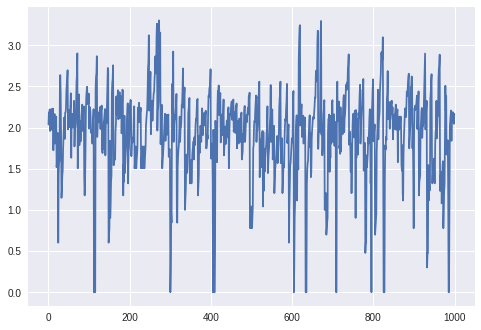

In [4]:
from matplotlib import pyplot as plt

temp = [float_data[i, 0] for i in range(1000)]
# temp = float_data[:]
plt.plot(range(len(temp)), temp)

In [0]:
from keras import activations
from keras import losses
from keras import metrics
from keras import optimizers
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers import GRU, LSTM, CuDNNGRU
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [7]:
mean = float_data[:80000].mean(axis=0)
float_data -= mean

std = float_data[:80000].std(axis=0)
float_data /= std

mean , std

(array([1.89209157e+00, 2.50000000e+00, 5.15454000e+01, 4.19000000e-02,
        5.34005000e+00, 1.03149003e+03, 1.73552454e+03, 8.98675000e-01,
        9.28375000e-02, 1.64325000e+00, 3.58312625e+01, 3.47875000e-02]),
 array([5.28723780e-01, 1.11803399e+00, 1.24818604e+01, 5.67577651e-01,
        2.05315391e+00, 6.12225790e+02, 1.58068457e+03, 2.45484383e+00,
        4.18740610e-01, 5.46675807e-01, 2.28644148e+01, 2.08092119e-01]))

In [8]:
train_generator_GRU = TimeseriesGenerator(float_data, 
                                              float_target, 
                                              length=3, 
                                              batch_size=10, 
                                              shuffle=False, 
                                              stride=4,
                                              sampling_rate=1,
                                              start_index=0,
                                              end_index=80000)

validation_generator_GRU = TimeseriesGenerator(float_data, 
                                                  float_target, 
                                                  length=3, 
                                                  batch_size=10, 
                                                  shuffle=False, 
                                                  stride=4,
                                                  sampling_rate=1,
                                                  start_index=80000,
                                                  end_index=90000)

test_generator_GRU = TimeseriesGenerator(float_data, 
                                            float_target, 
                                            length=3, 
                                            sampling_rate=1,
                                            batch_size=10, 
                                            shuffle=False, 
                                            stride=4,
                                            start_index=90000,
                                            end_index=None)

sample_len = len(train_generator_GRU)
print('Samples: %d' %sample_len)
validation_len = len(validation_generator_GRU)
print('Validations: %d' %validation_len)
test_len = len(test_generator_GRU)
print('Tests: %d' %test_len)

# print(train_generator_GRU[0])

Samples: 2000
Validations: 250
Tests: 330


In [9]:

model_GRU = Sequential()
model_GRU.add(CuDNNGRU(200, input_shape=(3, 12), return_sequences=True))
model_GRU.add(CuDNNGRU(100, return_sequences=False))
model_GRU.add(Dense(128, activation='relu'))
model_GRU.add(BatchNormalization())
model_GRU.add(Dropout(0.5))
model_GRU.add(Dense(64, activation='relu'))
model_GRU.add(BatchNormalization())
model_GRU.add(Dropout(0.2))
model_GRU.add(Dense(1))

model_GRU.compile(optimizer='RMSprop', loss='mae')
model_GRU.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, 3, 200)            128400    
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 100)               90600     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               12928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
__________

In [0]:
history_GRU = model_GRU.fit_generator(train_generator_GRU, 
                                          validation_steps= validation_len,
                                          validation_data= validation_generator_GRU,
                                          steps_per_epoch=sample_len, 
                                          epochs=50, 
                                          shuffle=True, 
                                          verbose=1)

Epoch 1/50
 926/2000 [============>.................] - ETA: 15s - loss: 0.7680

In [0]:
# model = Sequential()
# model.add(Dense(256, activation='relu', 
#                              input_shape=(len(header)-1,)))
# model.add(Dropout(0.5))
# # model.add(layers.BatchNormalization())

# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))

# model.add(Dense(1))

# model.compile(optimizer='RMSprop', loss='MAE')

# # ----------------------
# # ----------------------
# history = model.fit(x_train, y_train, epochs=20, shuffle=True, batch_size=4, validation_split=0.1)

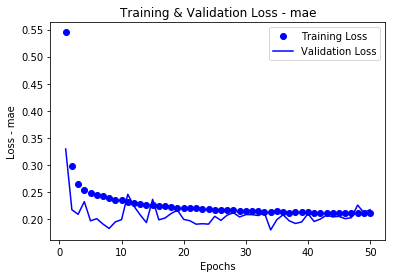

In [0]:
import matplotlib.pyplot as plt

history_dict = history_GRU.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.title('Training & Validation Loss - mae')
plt.xlabel('Epochs')
plt.ylabel('Loss - mae')
plt.legend()
plt.show()

In [0]:
# model.evaluate(x_test, y_test, batch_size=32)

In [0]:
# model.predict(x_test[:10]) 

In [0]:
# y_test[:10]

In [0]:
# history_dict

In [0]:
model_GRU.evaluate_generator(generator=test_generator_GRU)

0.15182563076883962

In [0]:
np.power(10, model_GRU.predict(test_generator_GRU[0][0]))

array([[137.47595 ],
       [ 93.80192 ],
       [ 99.08549 ],
       [134.93529 ],
       [ 73.42188 ],
       [ 50.185493],
       [ 10.916839],
       [ 24.09898 ],
       [ 12.323924],
       [ 34.085358]], dtype=float32)

In [0]:
np.power(10, test_generator_GRU[0][1])

array([135.99999988,  90.99999993,  94.00000009, 133.00000001,
        62.99999993,  36.00000002,   4.        ,  12.        ,
         7.        ,  23.        ])